# Introduction to Image Segmentation.

# =====

## Import the required libraries


In [1]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt


## Loading the image
### We define a function “imshow” to display the processed image. The code loads an image named “1678598671986.jpeg“. You'll find it in the dataset folder in the drive.



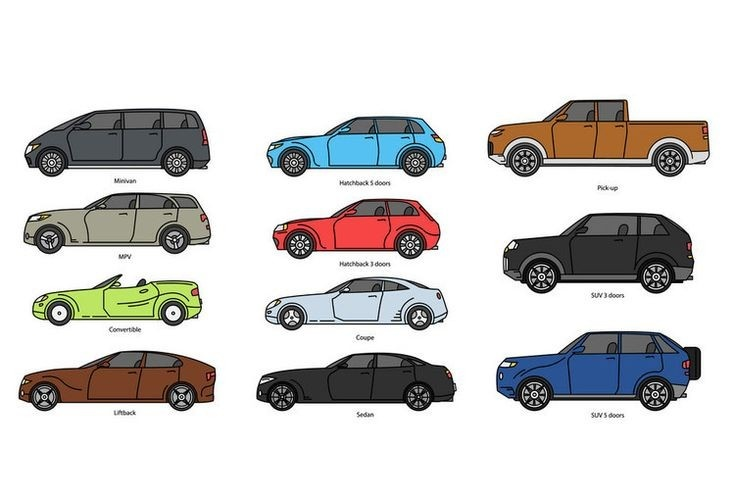

In [3]:
# Plot the image
def imshow(img, ax=None):
	if ax is None:
		ret, encoded = cv2.imencode(".jpg", img)
		display(Image(encoded))
	else:
		ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
		ax.axis('off')

#Image loading
img = cv2.imread("/content/1678598671986.jpeg")
# Show image
imshow(img)


## Coverting to Grayscale image
### We convert the image to grayscale using OpenCV’s “cvtColor” method. The grayscale image is stored in a variable “gray”.



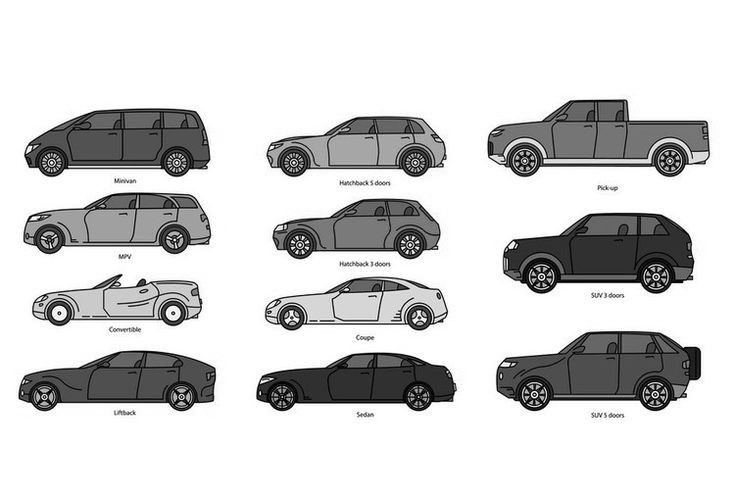

In [4]:
#image grayscale conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

The cv2.cvtColor() function takes two arguments: the image and the conversion flag cv2.COLOR_BGR2GRAY, which specifies the conversion from BGR color space to grayscale.

Implementing thresholding
A crucial step in image segmentation is thresholding, which changes a grayscale image into a binary image. It is essential for distinguishing the items of attention from the backdrop.

When using the cv2.THRESH_BINARY_INV thresholding method in OpenCV, the cv2.THRESH_OTSU parameter is added to apply Otsu’s binarization process. Otsu’s method automatically determines an optimal threshold by maximizing the variance between two classes of pixels in the image. It aims to find a threshold that minimizes intra-class variance and maximizes inter-class variance, effectively separating the image into two groups of pixels with distinct characteristics.



Otsu’s binarization process

Otsu’s binarization is a technique used in image processing to separate the foreground and background of an image into two distinct classes. This is done by finding the optimal threshold value that maximizes the variance between the two classes. Otsu’s method is known for its simplicity and computational efficiency, making it a popular choice in applications such as document analysis, object recognition, and medical imaging.



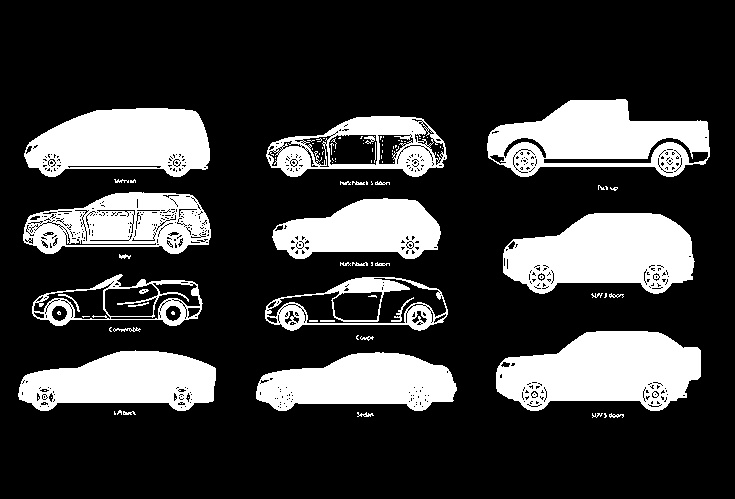

In [5]:
#Threshold Processing
ret, bin_img = cv2.threshold(gray,
							0, 255,
							cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imshow(bin_img)

## Noise Removal
### To clean the object’s outline (boundary line), noise is removed using morphological gradient processing.


=====

Morphological Gradient Processing

The morphological gradient is a tool used in morphological image processing to emphasize the edges and boundaries of objects in an image. It is obtained by subtracting the erosion of an image from its dilation. Erosion shrinks bright regions in an image, while dilation expands them, and the morphological gradient represents the difference between the two. This operation is useful in tasks such as object detection and segmentation, and it can also be combined with other morphological operations to enhance or filter specific features in an image.





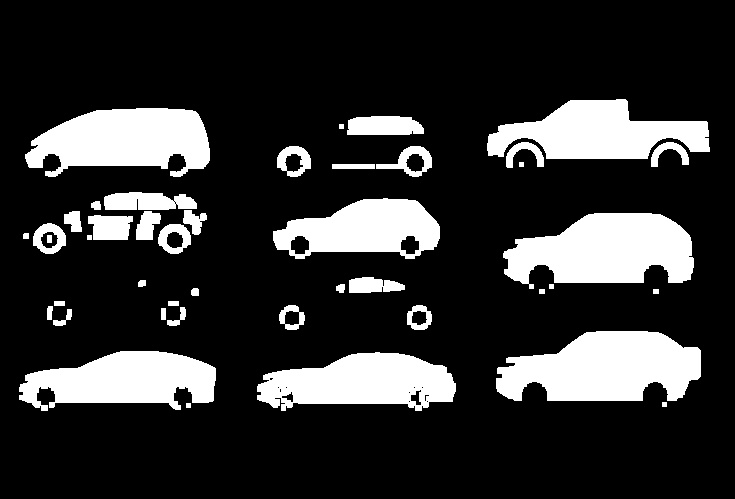

In [6]:
# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img,
						cv2.MORPH_OPEN,
						kernel,
						iterations=2)
imshow(bin_img)

### Detecting the black background and foreground of the image
Next, we need to get a hold of the black area, which is the background part of this image. If the white part is the required area and is well-filled, that means the rest is the background.

We apply several morphological operations on our binary image:

The first operation is dilation using “cv2.dilate” which expands the bright regions of the image, creating the “sure_bg” variable representing the sure background area. This result is displayed using the “imshow” function.
 The next operation is “cv2.distanceTransform” which calculates the distance of each white pixel in the binary image to the closest black pixel. The result is stored in the “dist” variable and displayed using “imshow”.
Then, the foreground area is obtained by applying a threshold on the “dist” variable using “cv2.threshold”. The threshold is set to 0.5 times the maximum value of “dist”.
Finally, the unknown area is calculated as the difference between the sure background and sure foreground areas using “cv2.subtract”. The result is stored in the “unknown” variable and displayed using “imshow”.


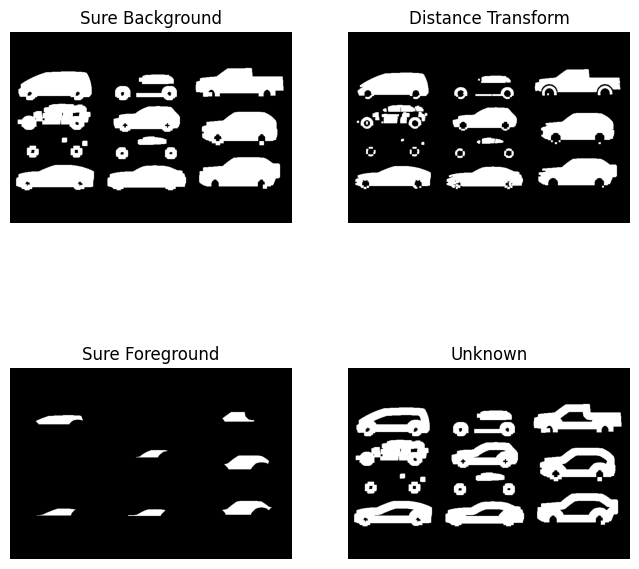

In [7]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')

#foreground area
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')

# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')

plt.show()


## Creating marker image
There is a gray area between the white area in this part of the background and the clearly visible white part of the foreground. This is still uncharted territory, an undefined part. Sow we will subtract this area.

Here are the steps:

1. First, the “connectedcomponents” method from OpenCV is used to find the connected components in the sure foreground image “sure_fg”. The result is stored in “markers”.
2. To distinguish the background and foreground, the values in “markers” are incremented by 1.
3. The unknown region, represented by pixels with a value of 255 in “unknown”, is labeled with 0 in “markers”.
4. Finally, the “markers” image is displayed using Matplotlib’s “imshow” method with a color map of “tab20b”. The result is shown in a figure of size 6×6.


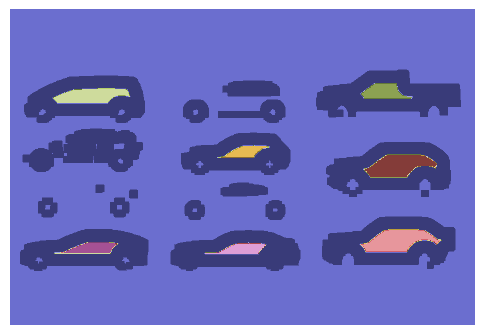

In [8]:
# Marker labelling
# sure foreground
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


This marker image, created by labeling the sure foreground and marking the unknown region, serves as input to the Watershed Algorithm. It guides the algorithm in segmenting the image based on these labeled regions. Each distinct color or label represents a separate segment or region in the image

Applying Watershed Algorithm to Markers

Applying watershed() function. Steps taken:

The “cv2.watershed” function is applied to the original image “img” and the markers image obtained in the previous step to perform the Watershed algorithm. The result is stored in “markers”.
The “markers” image is displayed using Matplotlib’s “imshow” method with a color map of “tab20b”.
A loop iterates over the labels starting from 2 (ignoring the background and unknown regions) to extract the contours of each object.
The contours of the binary image are found using OpenCV’s “findContours” function, and the first contour is appended to a list of coins.
Finally, the objects’ outlines are drawn on the original image using “cv2.drawContours”. The result is displayed using the “imshow” function.


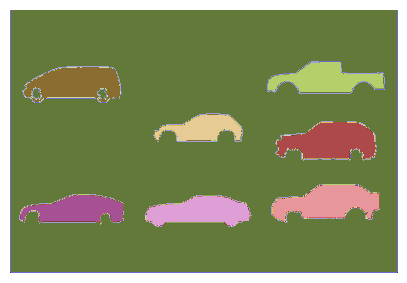

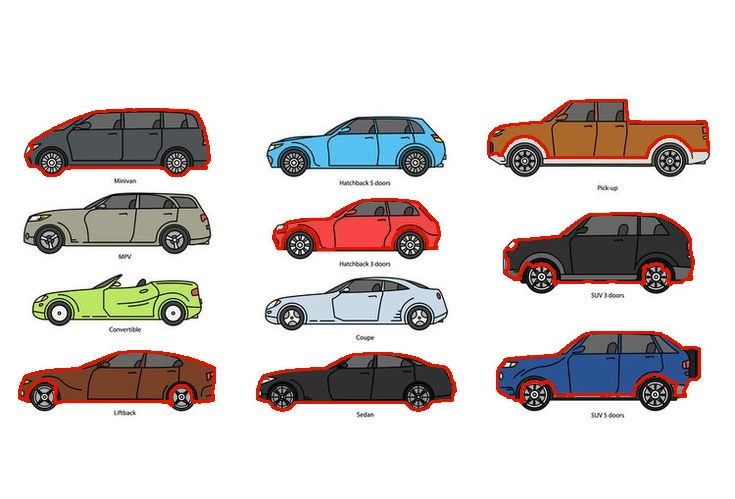

In [9]:
# watershed Algorithm
markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]:

# Create a binary image in which only the area of the label is in the foreground
#and the rest of the image is in the background
	target = np.where(markers == label, 255, 0).astype(np.uint8)

# Perform contour extraction on the created binary image
	contours, hierarchy = cv2.findContours(
		target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
	)
	coins.append(contours[0])

# Draw the outline
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
imshow(img)


### The outline of each object is drawn in red in the image.

Hence, the code implements the watershed algorithm using OpenCV to segment an image into separate objects or regions. The code first loads the image and converts it to grayscale, performs some preprocessing steps, places markers on the local minima, floods the image with different colors, and finally identifies the boundaries between the regions. The resulting segmented image is then displayed.

